#### This notebook demonstrates the use of an odds-equalizing post-processing algorithm for bias mitigiation.


In [1]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.insert(0, '/home/jl0274/AIF360')
import numpy as np
import pandas as pd

sys.path.append("../")
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
                import load_preproc_data_adult

from sklearn.preprocessing import scale
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from common_utils import compute_metrics

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


### Fairness metrics for original dataset

In [2]:
import aif360
aif360.__file__

'/home/jl0274/AIF360/aif360/__init__.py'

In [3]:
## import dataset
dataset_used = "adult" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2

if dataset_used == "adult":
    # dataset_orig = AdultDataset()
    dataset_orig = load_preproc_data_adult()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
# cost constraint of fnr will optimize generalized false negative rates, that of
# fpr will optimize generalized false positive rates, and weighted will optimize
# a weighted combination of both
cost_constraint = "fnr" # "fnr", "fpr", "weighted"
#random seed for calibrated equal odds prediction
randseed = 12345679 

standard dataset: is na? False


#### Divide dataset into train, validation, and test partitions (70-30)

In [4]:
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#### Training data characteristics

In [5]:
# print out some labels, names, etc.
display(Markdown("#### Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Dataset shape

(827046, 21)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([0.])] [array([1.])]


#### Dataset feature names

['hoepa_status_2.0', 'hoepa_status_3.0', 'total_loan_costs', 'rate_spread', 'interest_rate', 'origination_charges', 'lender_credits', 'derived_dwelling_category_Single Family (1-4 Units):Site-Built', 'loan_term', 'discount_points', 'construction_method_2.0', 'tract_to_msa_income_percentage', 'combined_loan_to_value_ratio', 'tract_population', 'tract_minority_population_percent', 'property_value', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes', 'purchaser_type_1.0', 'income', 'sex']


#### Metric for the original datasets (without any classifiers)

In [6]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

metric_orig_valid = BinaryLabelDatasetMetric(dataset_orig_valid, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original validation dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_valid.mean_difference())

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.053328


#### Original validation dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.050683


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.053634


## Gender Present

### Train classifier (logistic regression on original training data)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

# Placeholder for predicted and transformed datasets
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

dataset_new_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

# xgboost classifier and predictions for training data
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()
params = {
    'learning_rate': 0.1,
    'max_depth': 7,
    'subsample': 0.7
}

xg_model = xgb.XGBClassifier(**params)  # Use XGBRegressor for regression tasks
xg_model.fit(X_train, y_train,
            sample_weight=dataset_orig_train.instance_weights)

fav_idx = np.where(xg_model.classes_ == dataset_orig_train.favorable_label)[0][0]
y_train_pred_prob = xg_model.predict_proba(X_train)[:,fav_idx]

# Prediction probs for validation and testing data
X_valid = dataset_orig_valid.features
y_valid_pred_prob = xg_model.predict_proba(X_valid)[:,fav_idx]

X_test = dataset_orig_test.features
y_test_pred_prob = xg_model.predict_proba(X_test)[:,fav_idx]

class_thresh = 0.5
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)
dataset_orig_valid_pred.scores = y_valid_pred_prob.reshape(-1,1)
dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

y_valid_pred = np.zeros_like(dataset_orig_valid_pred.labels)
y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_valid_pred.favorable_label
y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_valid_pred.unfavorable_label
dataset_orig_valid_pred.labels = y_valid_pred
    
y_test_pred = np.zeros_like(dataset_orig_test_pred.labels)
y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_test_pred.favorable_label
y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_test_pred.unfavorable_label
dataset_orig_test_pred.labels = y_test_pred

### Fairness and accuracy metrics with theshold = 0.5

In [8]:
metric_orig_test_pred = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print(f"DIM in outcome: {metric_orig_test_pred.mean_difference()}")

DIM in outcome: 0.05363396197365056


In [9]:
compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = True)

Balanced accuracy = 0.9901
Statistical parity difference = 0.0514
Disparate impact = 1.0718
Average odds difference = -0.0001
Equal opportunity difference = -0.0023
Theil index = 0.0096


OrderedDict([('Balanced accuracy', 0.9901349509069131),
             ('Statistical parity difference', 0.05143825800358959),
             ('Disparate impact', 1.0718325686947743),
             ('Average odds difference', -8.390596884319534e-05),
             ('Equal opportunity difference', -0.0022700334761008856),
             ('Theil index', 0.009611011465981239)])

In [10]:
# inputs should be y_test, dataset_orig_test_pred.labels, dataset_orig_test_pred.scores respectively 
def accuracy_scores(y_true, preds, y_pred_scores, best_class_thresh):
    # F1 score
    y_pred = (y_pred_scores > best_class_thresh).astype(int)
    y_pred[y_pred == 1] = preds.favorable_label
    y_pred[y_pred == 0] = preds.unfavorable_label
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1:.4f}")
    # AUC
    auc = roc_auc_score(y_true, dataset_orig_test_pred.scores)
    print(f"ROC AUC Score: {auc:.4f}")
    
    return f1, auc
    
f1, auc = accuracy_scores(dataset_orig_test.labels, dataset_orig_test_pred, dataset_orig_test_pred.scores, 0.5)

F1 Score: 0.9928
ROC AUC Score: 0.9993


In [11]:
# bias summary metrics
def bias_summary_metrics(gender_col, target):
    # test whether loan approval significantly depends on gender
    gender_col = pd.Series(gender_col)  # Convert gender to categorical
    target = pd.Series(target.ravel())

    # Create a contingency table
    contingency_table = pd.crosstab(gender_col, target)
    
    # Perform the Chi-Square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p_value}")
    
    if p_value < 0.05:
        print("There is a significant association between gender and loan approval.")
    else:
        print("There is no significant association between gender and loan approval.")

    # test whether there's a significant difference in loan approval proportions across men vs women

    # Count of approvals for men and women
    men_approved = sum((gender_col == 0) & (target == 1))
    women_approved = sum((gender_col == 1) & (target == 1))
    
    # Total number of applicants in each group
    men_total = sum(gender_col == 0)
    women_total = sum(gender_col == 1)
    
    # Run the Z-test
    count = [men_approved, women_approved]
    nobs = [men_total, women_total]
    stat, p_value = proportions_ztest(count, nobs)
    
    print(f"Z-statistic: {stat}")
    print(f"P-value: {p_value:10e}")
    
    if p_value < 0.05:
        print("There is a significant difference in loan approval rates between men and women.")
    else:
        print("There is no significant difference in loan approval rates between men and women.")

    men_approved_prop = men_approved/men_total
    women_approved_prop = women_approved/women_total
    print(f'male approval rate: {men_approved_prop}')
    print(f'female approval rate: {women_approved_prop}')
    

In [12]:
bias_summary_metrics(X_test[:, -1], dataset_orig_test_pred.labels)

Chi-Square Statistic: 566.2990617482782
P-value: 3.5840559871774464e-125
There is a significant association between gender and loan approval.
Z-statistic: 23.802796209268504
P-value: 3.124366e-125
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.7675237180984009
female approval rate: 0.7160854600948113


#### Results before post-processing

In [13]:
cm_pred_train = ClassificationMetric(dataset_orig_train, dataset_orig_train_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted training dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_negative_rate))

cm_pred_valid = ClassificationMetric(dataset_orig_valid, dataset_orig_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate))

cm_pred_test = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_negative_rate))

#### Original-Predicted training dataset

Difference in GFPR between unprivileged and privileged groups
0.01494129542596959
Difference in GFNR between unprivileged and privileged groups
0.002708294351865998


#### Original-Predicted validation dataset

Difference in GFPR between unprivileged and privileged groups
0.01671133321741994
Difference in GFNR between unprivileged and privileged groups
0.0022401473922185056


#### Original-Predicted testing dataset

Difference in GFPR between unprivileged and privileged groups
0.014218694246103405
Difference in GFNR between unprivileged and privileged groups
0.0022072100058749076


### Perform odds equalizing post processing on scores

In [14]:
# Odds equalizing post-processing algorithm
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from tqdm import tqdm

# Learn parameters to equalize odds and apply to create a new dataset
cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)
cpp = cpp.fit(dataset_orig_valid, dataset_orig_valid_pred)

### Transform validation and test data using the post processing algorithm

In [15]:
dataset_transf_valid_pred = cpp.predict(dataset_orig_valid_pred)
dataset_transf_test_pred = cpp.predict(dataset_orig_test_pred)

#### Results after post-processing

In [16]:
cm_transf_valid = ClassificationMetric(dataset_orig_valid, dataset_transf_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate))

cm_transf_test = ClassificationMetric(dataset_orig_test, dataset_transf_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_negative_rate))

#### Original-Transformed validation dataset

Difference in GFPR between unprivileged and privileged groups
0.01126738941937152
Difference in GFNR between unprivileged and privileged groups
-0.00011801477737684134


#### Original-Transformed testing dataset

Difference in GFPR between unprivileged and privileged groups
0.007916446542073262
Difference in GFNR between unprivileged and privileged groups
-2.49850794633074e-05


### Fairness and Accuracy Metrics for post-processed data

In [17]:
metric_transf_test_pred = BinaryLabelDatasetMetric(dataset_transf_test_pred, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print(f"DIM in outcome: {metric_transf_test_pred.mean_difference()}")

DIM in outcome: 0.04888939119405644


In [18]:
compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = True)

Balanced accuracy = 0.9884
Statistical parity difference = 0.0489
Disparate impact = 1.0680
Average odds difference = -0.0046
Equal opportunity difference = -0.0023
Theil index = 0.0099


OrderedDict([('Balanced accuracy', 0.9883619559284624),
             ('Statistical parity difference', 0.04888939119405644),
             ('Disparate impact', 1.0680309711959584),
             ('Average odds difference', -0.004606145906151589),
             ('Equal opportunity difference', -0.002337538707756437),
             ('Theil index', 0.00992881686636406)])

In [19]:
# Testing: Check if the rates for validation data has gone down
assert np.abs(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate)) < np.abs(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate)) 

In [20]:
# Thresholds
all_thresh = np.linspace(0.01, 0.99, 25)
display(Markdown("#### Classification thresholds used for validation and parameter selection"))

bef_avg_odds_diff_test = []
bef_avg_odds_diff_valid = []
aft_avg_odds_diff_test = []
aft_avg_odds_diff_valid = []
bef_bal_acc_valid = []
bef_bal_acc_test = []
aft_bal_acc_valid = []
aft_bal_acc_test = []
for thresh in tqdm(all_thresh):
    
    dataset_orig_valid_pred_thresh = dataset_orig_valid_pred.copy(deepcopy=True)
    dataset_orig_test_pred_thresh = dataset_orig_test_pred.copy(deepcopy=True)
    dataset_transf_valid_pred_thresh = dataset_transf_valid_pred.copy(deepcopy=True)
    dataset_transf_test_pred_thresh = dataset_transf_test_pred.copy(deepcopy=True)
    
    # Labels for the datasets from scores
    y_temp = np.zeros_like(dataset_orig_valid_pred_thresh.labels)
    y_temp[dataset_orig_valid_pred_thresh.scores >= thresh] = dataset_orig_valid_pred_thresh.favorable_label
    y_temp[~(dataset_orig_valid_pred_thresh.scores >= thresh)] = dataset_orig_valid_pred_thresh.unfavorable_label
    dataset_orig_valid_pred_thresh.labels = y_temp

    y_temp = np.zeros_like(dataset_orig_test_pred_thresh.labels)
    y_temp[dataset_orig_test_pred_thresh.scores >= thresh] = dataset_orig_test_pred_thresh.favorable_label
    y_temp[~(dataset_orig_test_pred_thresh.scores >= thresh)] = dataset_orig_test_pred_thresh.unfavorable_label
    dataset_orig_test_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_valid_pred_thresh.labels)
    y_temp[dataset_transf_valid_pred_thresh.scores >= thresh] = dataset_transf_valid_pred_thresh.favorable_label
    y_temp[~(dataset_transf_valid_pred_thresh.scores >= thresh)] = dataset_transf_valid_pred_thresh.unfavorable_label
    dataset_transf_valid_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_test_pred_thresh.labels)
    y_temp[dataset_transf_test_pred_thresh.scores >= thresh] = dataset_transf_test_pred_thresh.favorable_label
    y_temp[~(dataset_transf_test_pred_thresh.scores >= thresh)] = dataset_transf_test_pred_thresh.unfavorable_label
    dataset_transf_test_pred_thresh.labels = y_temp
    
    # Metrics for original validation data
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                                 dataset_orig_valid_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_valid.append(classified_metric_orig_valid.equal_opportunity_difference())

    bef_bal_acc_valid.append(0.5*(classified_metric_orig_valid.true_positive_rate()+
                              classified_metric_orig_valid.true_negative_rate()))

    classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_orig_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
    bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
                              classified_metric_orig_test.true_negative_rate()))

    # Metrics for transf validing data
    classified_metric_transf_valid = ClassificationMetric(
                                     dataset_orig_valid, 
                                     dataset_transf_valid_pred_thresh,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)
    aft_avg_odds_diff_valid.append(classified_metric_transf_valid.equal_opportunity_difference())
    aft_bal_acc_valid.append(0.5*(classified_metric_transf_valid.true_positive_rate()+
                              classified_metric_transf_valid.true_negative_rate()))

    # Metrics for transf validation data
    classified_metric_transf_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_transf_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
    aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
                                  classified_metric_transf_test.true_negative_rate()))


#### Classification thresholds used for validation and parameter selection

100%|██████████| 25/25 [01:09<00:00,  2.78s/it]


In [21]:
classified_metric_transf_test.precision

<bound method ClassificationMetric.precision of <aif360.metrics.classification_metric.ClassificationMetric object at 0x7fbafb4f62d0>>

In [22]:
# accuracy metrics
f1 = (2 * classified_metric_transf_test.precision() * classified_metric_transf_test.recall()) / (classified_metric_transf_test.precision() + classified_metric_transf_test.recall())
auc = roc_auc_score(dataset_orig_test.labels, dataset_transf_test_pred_thresh.scores)
print(f"f1 score: {f1}")
print(f"auc score: {auc}")

f1 score: 0.9837482186713563
auc score: 0.9992024628773066


In [23]:
bias_summary_metrics(X_test[:, -1], dataset_transf_test_pred.labels)

Chi-Square Statistic: 512.764798264327
P-value: 1.5873653053658972e-113
There is a significant association between gender and loan approval.
Z-statistic: 22.650074594902467
P-value: 1.392752e-113
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.7675237180984009
female approval rate: 0.7186343269043445


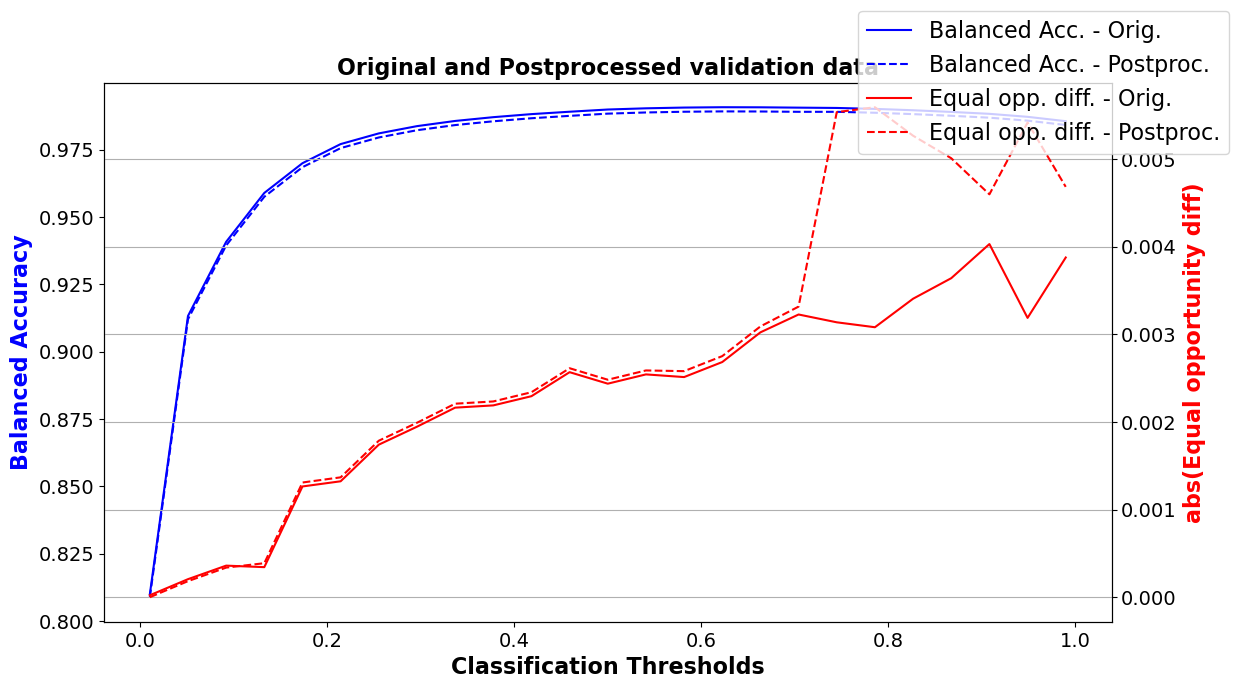

In [24]:
bef_bal_acc_valid = np.array(bef_bal_acc_valid)
bef_avg_odds_diff_valid = np.array(bef_avg_odds_diff_valid)

aft_bal_acc_valid = np.array(aft_bal_acc_valid)
aft_avg_odds_diff_valid = np.array(aft_avg_odds_diff_valid)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_valid, color='b')
ax1.plot(all_thresh, aft_bal_acc_valid, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed validation data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_valid), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_valid), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
             "Equal opp. diff. - Orig.","Equal opp. diff. - Postproc.",], 
           fontsize=16)
# plt.savefig("eqodds-logreg-val")

plt.show()

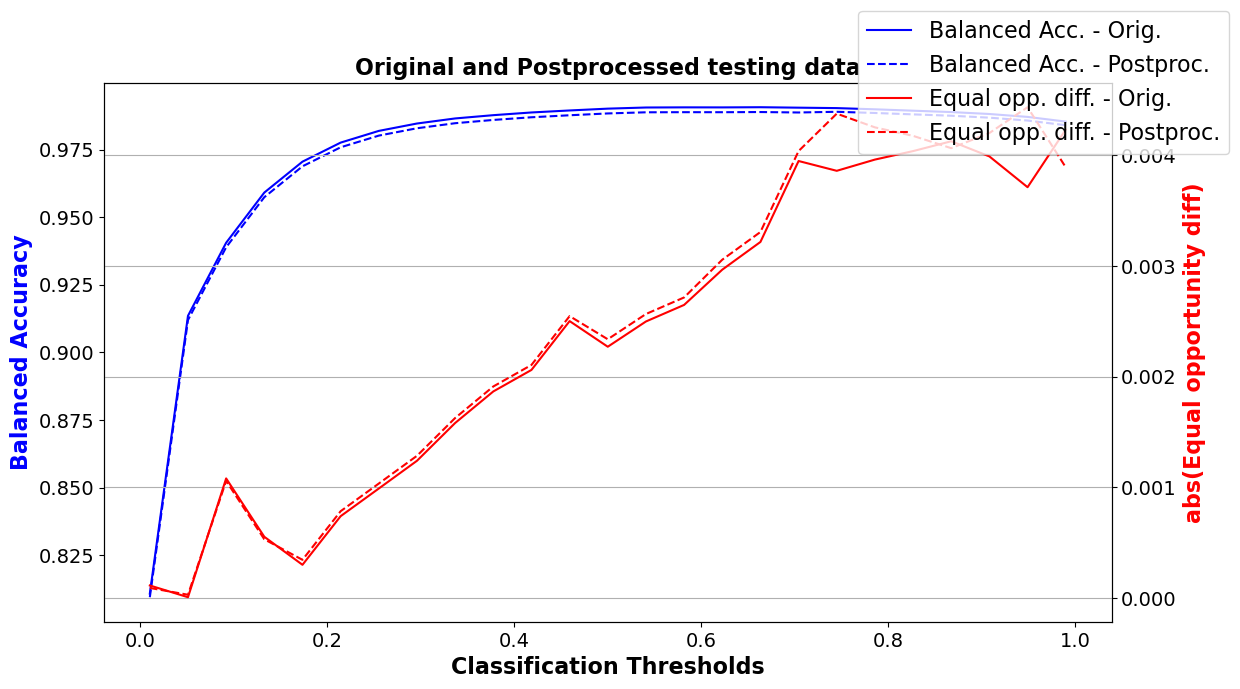

In [25]:
bef_bal_acc_test = np.array(bef_bal_acc_test)
bef_avg_odds_diff_test = np.array(bef_avg_odds_diff_test)

aft_bal_acc_test = np.array(aft_bal_acc_test)
aft_avg_odds_diff_test = np.array(aft_avg_odds_diff_test)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_test, color='b')
ax1.plot(all_thresh, aft_bal_acc_test, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed testing data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_test), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_test), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
            "Equal opp. diff. - Orig.", "Equal opp. diff. - Postproc."], 
           fontsize=16)

plt.savefig("eqodds-xg-eqopp-gen")

plt.show()

In [26]:
classified_metric_orig_test

## Gender Not Present

### Train classifier (logistic regression on original training data)

In [27]:
gender_col = X_test[:, -1]

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

# Placeholder for predicted and transformed datasets
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

dataset_new_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

# Logistic regression classifier and predictions for training data
X_train = dataset_orig_train.features[:, :-1]
y_train = dataset_orig_train.labels.ravel()


params = {
    'learning_rate': 0.1,
    'max_depth': 7,
    'subsample': 0.7
}

xg_model = xgb.XGBClassifier(**params)
xg_model.fit(X_train, y_train)

fav_idx = np.where(xg_model.classes_ == dataset_orig_train.favorable_label)[0][0]
y_train_pred_prob = xg_model.predict_proba(X_train)[:,fav_idx]

# Prediction probs for validation and testing data
X_valid = dataset_orig_valid.features[:, :-1]
y_valid_pred_prob = xg_model.predict_proba(X_valid)[:,fav_idx]

X_test = dataset_orig_test.features[:, :-1]
y_test_pred_prob = xg_model.predict_proba(X_test)[:,fav_idx]

class_thresh = 0.5
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)
dataset_orig_valid_pred.scores = y_valid_pred_prob.reshape(-1,1)
dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

y_valid_pred = np.zeros_like(dataset_orig_valid_pred.labels)
y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_valid_pred.favorable_label
y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_valid_pred.unfavorable_label
dataset_orig_valid_pred.labels = y_valid_pred
    
y_test_pred = np.zeros_like(dataset_orig_test_pred.labels)
y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_test_pred.favorable_label
y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_test_pred.unfavorable_label
dataset_orig_test_pred.labels = y_test_pred

### Fairness and accuracy metrics with theshold = 0.5

In [29]:
metric_orig_test_pred = BinaryLabelDatasetMetric(dataset_orig_test_pred, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print(f"DIM in outcome: {metric_orig_test_pred.mean_difference()}")

DIM in outcome: 0.05103132561403523


In [30]:
compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = True)

Balanced accuracy = 0.9902
Statistical parity difference = 0.0510
Disparate impact = 1.0712
Average odds difference = -0.0005
Equal opportunity difference = -0.0027
Theil index = 0.0095


OrderedDict([('Balanced accuracy', 0.9901710536525873),
             ('Statistical parity difference', 0.05103132561403523),
             ('Disparate impact', 1.0712255400281454),
             ('Average odds difference', -0.0004503154600901866),
             ('Equal opportunity difference', -0.002731225705941198),
             ('Theil index', 0.009509310302107053)])

In [31]:
f1, auc = accuracy_scores(dataset_orig_test.labels, dataset_orig_test_pred, dataset_orig_test_pred.scores, 0.5)

F1 Score: 0.9929
ROC AUC Score: 0.9993


In [32]:
bias_summary_metrics(gender_col, dataset_orig_test_pred.labels)

Chi-Square Statistic: 557.5564521949572
P-value: 2.8587416360636605e-123
There is a significant association between gender and loan approval.
Z-statistic: 23.618391549924656
P-value: 2.494666e-123
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.7675064213994759
female approval rate: 0.7164750957854407


#### Results before post-processing

In [33]:
cm_pred_train = ClassificationMetric(dataset_orig_train, dataset_orig_train_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted training dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_negative_rate))

cm_pred_valid = ClassificationMetric(dataset_orig_valid, dataset_orig_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate))

cm_pred_test = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_negative_rate))

#### Original-Predicted training dataset

Difference in GFPR between unprivileged and privileged groups
0.010103460109195283
Difference in GFNR between unprivileged and privileged groups
0.002931081826825858


#### Original-Predicted validation dataset

Difference in GFPR between unprivileged and privileged groups
0.012037894050659255
Difference in GFNR between unprivileged and privileged groups
0.0024760937629259867


#### Original-Predicted testing dataset

Difference in GFPR between unprivileged and privileged groups
0.009536221583173854
Difference in GFNR between unprivileged and privileged groups
0.00247535965714887


### Perform odds equalizing post processing on scores

In [34]:
# Odds equalizing post-processing algorithm
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from tqdm import tqdm

# Learn parameters to equalize odds and apply to create a new dataset
cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)
cpp = cpp.fit(dataset_orig_valid, dataset_orig_valid_pred)

### Transform validation and test data using the post processing algorithm

In [35]:
dataset_transf_valid_pred = cpp.predict(dataset_orig_valid_pred)
dataset_transf_test_pred = cpp.predict(dataset_orig_test_pred)

#### Results after post-processing

In [36]:
cm_transf_valid = ClassificationMetric(dataset_orig_valid, dataset_transf_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate))

cm_transf_test = ClassificationMetric(dataset_orig_test, dataset_transf_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_negative_rate))

#### Original-Transformed validation dataset

Difference in GFPR between unprivileged and privileged groups
0.00587347125528407
Difference in GFNR between unprivileged and privileged groups
-0.00013575496401156857


#### Original-Transformed testing dataset

Difference in GFPR between unprivileged and privileged groups
0.002311617858761987
Difference in GFNR between unprivileged and privileged groups
1.8651174508830734e-05


### Fairness and Accuracy Metrics for post-processed data

In [37]:
metric_transf_test_pred = BinaryLabelDatasetMetric(dataset_transf_test_pred, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print(f"DIM in outcome: {metric_transf_test_pred.mean_difference()}")

DIM in outcome: 0.04812529275475874


In [38]:
compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = True)

Balanced accuracy = 0.9881
Statistical parity difference = 0.0481
Disparate impact = 1.0669
Average odds difference = -0.0056
Equal opportunity difference = -0.0028
Theil index = 0.0099


OrderedDict([('Balanced accuracy', 0.9881278602844201),
             ('Statistical parity difference', 0.04812529275475874),
             ('Disparate impact', 1.0668981862860716),
             ('Average odds difference', -0.00563166302152122),
             ('Equal opportunity difference', -0.0027762291937114547),
             ('Theil index', 0.009882645738411952)])

In [39]:
# Testing: Check if the rates for validation data has gone down
assert np.abs(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate)) < np.abs(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate)) 

In [40]:
# Thresholds
all_thresh = np.linspace(0.01, 0.99, 25)
display(Markdown("#### Classification thresholds used for validation and parameter selection"))

bef_avg_odds_diff_test = []
bef_avg_odds_diff_valid = []
aft_avg_odds_diff_test = []
aft_avg_odds_diff_valid = []
bef_bal_acc_valid = []
bef_bal_acc_test = []
aft_bal_acc_valid = []
aft_bal_acc_test = []
for thresh in tqdm(all_thresh):
    
    dataset_orig_valid_pred_thresh = dataset_orig_valid_pred.copy(deepcopy=True)
    dataset_orig_test_pred_thresh = dataset_orig_test_pred.copy(deepcopy=True)
    dataset_transf_valid_pred_thresh = dataset_transf_valid_pred.copy(deepcopy=True)
    dataset_transf_test_pred_thresh = dataset_transf_test_pred.copy(deepcopy=True)
    
    # Labels for the datasets from scores
    y_temp = np.zeros_like(dataset_orig_valid_pred_thresh.labels)
    y_temp[dataset_orig_valid_pred_thresh.scores >= thresh] = dataset_orig_valid_pred_thresh.favorable_label
    y_temp[~(dataset_orig_valid_pred_thresh.scores >= thresh)] = dataset_orig_valid_pred_thresh.unfavorable_label
    dataset_orig_valid_pred_thresh.labels = y_temp

    y_temp = np.zeros_like(dataset_orig_test_pred_thresh.labels)
    y_temp[dataset_orig_test_pred_thresh.scores >= thresh] = dataset_orig_test_pred_thresh.favorable_label
    y_temp[~(dataset_orig_test_pred_thresh.scores >= thresh)] = dataset_orig_test_pred_thresh.unfavorable_label
    dataset_orig_test_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_valid_pred_thresh.labels)
    y_temp[dataset_transf_valid_pred_thresh.scores >= thresh] = dataset_transf_valid_pred_thresh.favorable_label
    y_temp[~(dataset_transf_valid_pred_thresh.scores >= thresh)] = dataset_transf_valid_pred_thresh.unfavorable_label
    dataset_transf_valid_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_test_pred_thresh.labels)
    y_temp[dataset_transf_test_pred_thresh.scores >= thresh] = dataset_transf_test_pred_thresh.favorable_label
    y_temp[~(dataset_transf_test_pred_thresh.scores >= thresh)] = dataset_transf_test_pred_thresh.unfavorable_label
    dataset_transf_test_pred_thresh.labels = y_temp
    
    # Metrics for original validation data
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                                 dataset_orig_valid_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_valid.append(classified_metric_orig_valid.equal_opportunity_difference())

    bef_bal_acc_valid.append(0.5*(classified_metric_orig_valid.true_positive_rate()+
                              classified_metric_orig_valid.true_negative_rate()))

    classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_orig_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
    bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
                              classified_metric_orig_test.true_negative_rate()))

    # Metrics for transf validing data
    classified_metric_transf_valid = ClassificationMetric(
                                     dataset_orig_valid, 
                                     dataset_transf_valid_pred_thresh,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)
    aft_avg_odds_diff_valid.append(classified_metric_transf_valid.equal_opportunity_difference())
    aft_bal_acc_valid.append(0.5*(classified_metric_transf_valid.true_positive_rate()+
                              classified_metric_transf_valid.true_negative_rate()))

    # Metrics for transf validation data
    classified_metric_transf_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_transf_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
    aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
                                  classified_metric_transf_test.true_negative_rate()))


#### Classification thresholds used for validation and parameter selection

100%|██████████| 25/25 [01:09<00:00,  2.77s/it]


In [41]:
# accuracy metrics
f1 = (2 * classified_metric_transf_test.precision() * classified_metric_transf_test.recall()) / (classified_metric_transf_test.precision() + classified_metric_transf_test.recall())
auc = roc_auc_score(dataset_orig_test.labels, dataset_transf_test_pred_thresh.scores)
print(f"f1 score: {f1}")
print(f"auc score: {auc}")

f1 score: 0.9838445009531099
auc score: 0.9991980769250353


In [42]:
bias_summary_metrics(gender_col, dataset_transf_test_pred.labels)

Chi-Square Statistic: 497.188404697225
P-value: 3.8879448954459505e-110
There is a significant association between gender and loan approval.
Z-statistic: 22.3034879683386
P-value: 3.417939e-110
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.7675064213994759
female approval rate: 0.7193811286447171


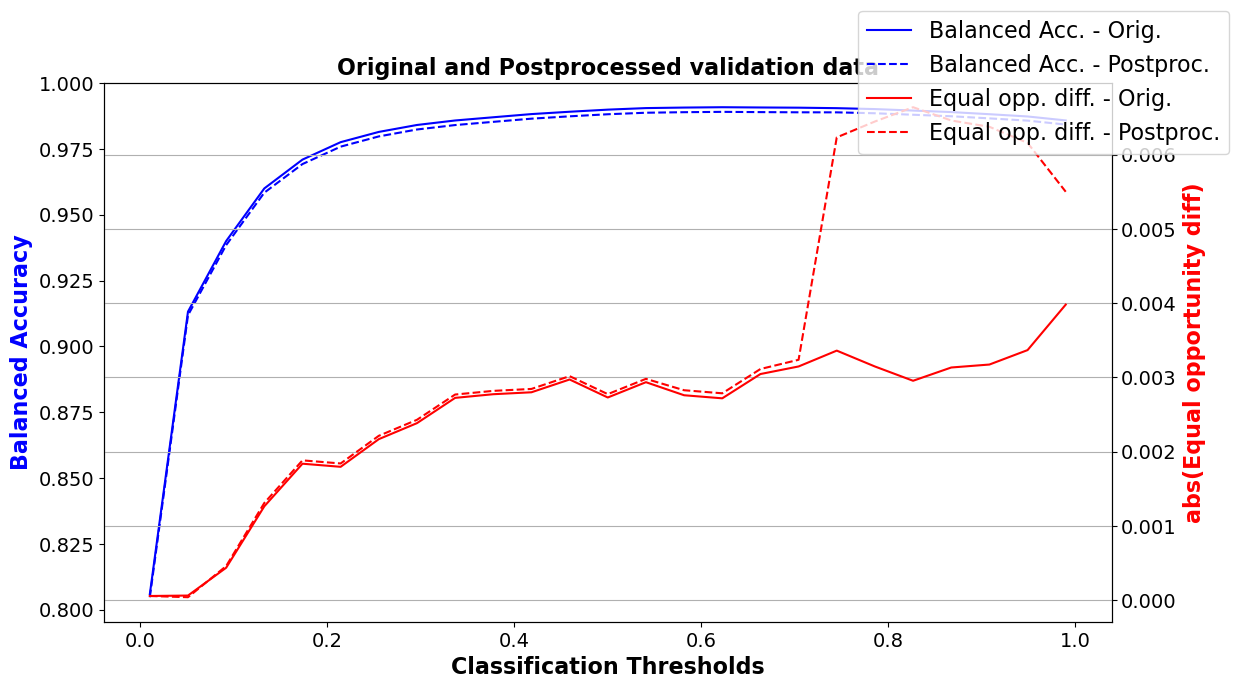

In [43]:
bef_bal_acc_valid = np.array(bef_bal_acc_valid)
bef_avg_odds_diff_valid = np.array(bef_avg_odds_diff_valid)

aft_bal_acc_valid = np.array(aft_bal_acc_valid)
aft_avg_odds_diff_valid = np.array(aft_avg_odds_diff_valid)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_valid, color='b')
ax1.plot(all_thresh, aft_bal_acc_valid, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed validation data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_valid), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_valid), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
             "Equal opp. diff. - Orig.","Equal opp. diff. - Postproc.",], 
           fontsize=16)
# plt.savefig("logreg-eqodds-val")

plt.show()

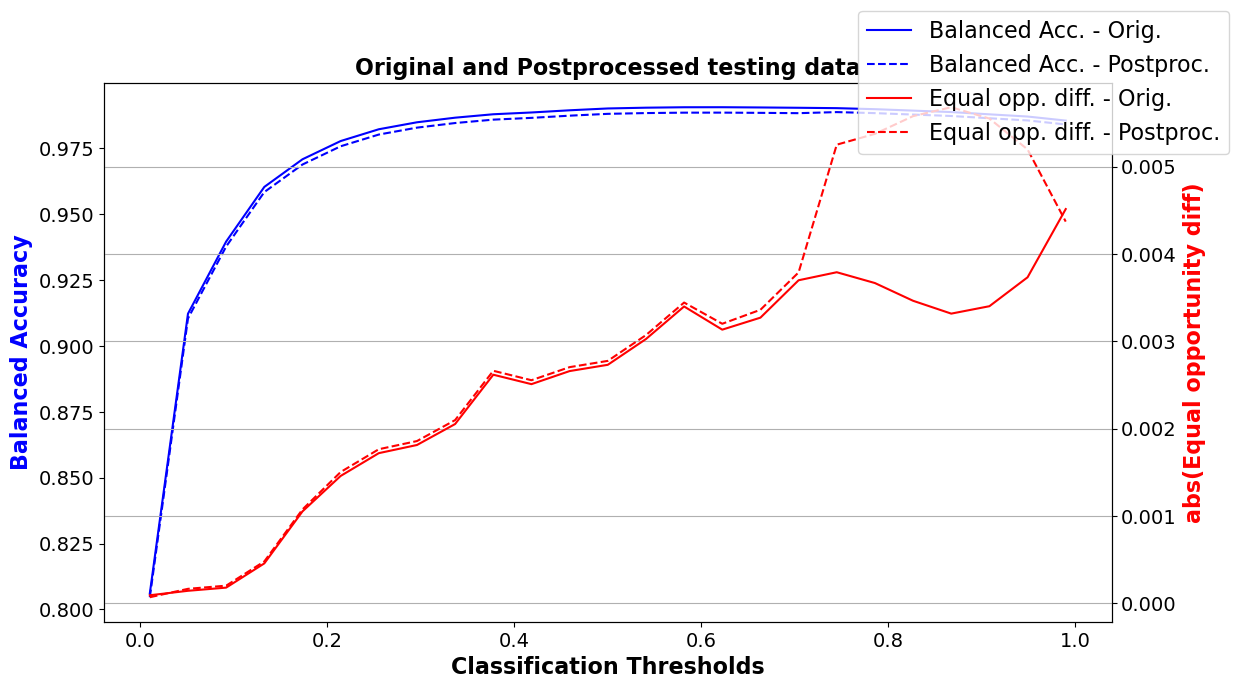

In [44]:
bef_bal_acc_test = np.array(bef_bal_acc_test)
bef_avg_odds_diff_test = np.array(bef_avg_odds_diff_test)

aft_bal_acc_test = np.array(aft_bal_acc_test)
aft_avg_odds_diff_test = np.array(aft_avg_odds_diff_test)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_test, color='b')
ax1.plot(all_thresh, aft_bal_acc_test, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed testing data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_test), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_test), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
            "Equal opp. diff. - Orig.", "Equal opp. diff. - Postproc."], 
           fontsize=16)

plt.savefig("eqodds-xg-eqopp-nogen")

plt.show()

In [45]:
classified_metric_orig_test